# Setup and load variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
thresh = 10**6 # sample expression threshold

In [3]:
expr = pd.read_csv("../../data/prepared/mouse.tsv.gz", sep="\t", header=0, index_col=[0,1])
print(expr.shape)
# rename the first column to "celltype"
idx = list(expr.index.names)
idx[0] = 'celltype'
expr.index.names = idx
expr.T.index.names = ['Gene']
expr.head().iloc[:,:5]

(1313, 31053)


Gene                      Xkr4  Gm1992  Gm37381  Rp1  Sox17
celltype        donor_id                                   
Astro Aqp4_Gfap F003        47       5        0    3      0
                F004        13       1        0    1      0
                F005        40       2        0    0      1
                F006         2       0        0    0      0
                F007         7       0        0    2      0

# First, filter samples

How many samples have fewer than $10^6$ reads?

In [4]:
celltype_sum = expr.sum(axis=1)
celltype_sum

celltype         donor_id
Astro Aqp4_Gfap  F003        1602304
                 F004        1123586
                 F005        1548083
                 F006         203221
                 F007         891005
                              ...   
Vip Sncg         M002         156961
                 M003          57257
                 M004          76019
                 M007          52030
                 M008         171551
Length: 1313, dtype: int64

In [5]:
num_celltypes = (celltype_sum > thresh).sum()
num_celltypes

322

(0.0, 10000000.0)

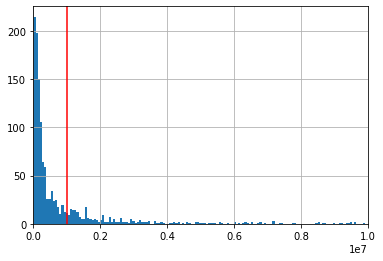

In [6]:
celltype_sum.hist(bins=1000)
plt.axvline(x=thresh, color='red')
plt.xlim([0, 10**7])

In [7]:
expr = expr.iloc[np.where(celltype_sum > thresh)[0]]
expr.shape

(322, 31053)

In [8]:
celltype_sum = celltype_sum[celltype_sum > thresh]
celltype_sum

celltype         donor_id
Astro Aqp4_Gfap  F003        1602304
                 F004        1123586
                 F005        1548083
                 F008        1929613
                 M002        1072272
                              ...   
Sst Hpse         F005        1182742
                 F008        1011971
Sst Pvalb Calb2  F005        1191605
                 F008        1323668
                 M008        1246468
Length: 322, dtype: int64

# Scale to CPM and add pseudocount

In [9]:
cpm = expr.divide(celltype_sum, axis=0)*thresh
cpm = expr + 1
cpm.head().iloc[:,:5]

Gene                      Xkr4  Gm1992  Gm37381  Rp1  Sox17
celltype        donor_id                                   
Astro Aqp4_Gfap F003        48       6        1    4      1
                F004        14       2        1    2      1
                F005        41       3        1    1      2
                F008         9       3        1    2      1
                M002        12       1        1    1      2

# Filter genes by CPM

Remove any genes with cumulative $CPM \le 1$ in more than half of the samples.

In [10]:
keep_genes = ((cpm <= 1).sum()/num_celltypes) < 0.5
print(f"Keeping {keep_genes.sum()} genes")
keep_genes

Keeping 18570 genes


Gene
Xkr4               True
Gm1992             True
Gm37381            True
Rp1                True
Sox17             False
                  ...  
AC168977.1        False
AC149090.1         True
CAAA01118383.1     True
Vmn2r122          False
CAAA01147332.1     True
Length: 31053, dtype: bool

In [11]:
cpm = cpm.loc[:,keep_genes]
cpm.shape

(322, 18570)

# Log transform

In [12]:
cpm = np.log(cpm)
cpm.head().iloc[:,:5]

Gene                          Xkr4    Gm1992  Gm37381       Rp1    Mrpl15
celltype        donor_id                                                 
Astro Aqp4_Gfap F003      3.871201  1.791759      0.0  1.386294  4.430817
                F004      2.639057  0.693147      0.0  0.693147  4.234107
                F005      3.713572  1.098612      0.0  0.000000  4.248495
                F008      2.197225  1.098612      0.0  0.693147  4.644391
                M002      2.484907  0.000000      0.0  0.000000  4.143135

# Scale so that celltypes sum to $log(10^6)$

In [13]:
cpm = cpm.divide(cpm.sum(axis=1), axis=0)*np.log(10**6)
cpm.head().iloc[:,:5]

Gene                          Xkr4    Gm1992  Gm37381       Rp1    Mrpl15
celltype        donor_id                                                 
Astro Aqp4_Gfap F003      0.000992  0.000459      0.0  0.000355  0.001135
                F004      0.000770  0.000202      0.0  0.000202  0.001235
                F005      0.000979  0.000290      0.0  0.000000  0.001120
                F008      0.000547  0.000274      0.0  0.000173  0.001157
                M002      0.000727  0.000000      0.0  0.000000  0.001213

# Retrieve gene correlation network

In [12]:
import igraph as ig
import leidenalg as la
# from umap import UMAP

In [13]:
from scipy.stats import rankdata

In [14]:
from numpy import corrcoef

In [16]:
corr = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [17]:
corr_human.shape

(1970, 1970)

In [18]:
def get_comparative_inds(corr_a, corr_b, n_idx = 30):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [19]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [20]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [21]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

(array([ 1.,  1.,  1.,  1.,  1.,  2.,  1.,  3.,  2.,  4.,  3.,  0.,  8.,
         5.,  3.,  6.,  7., 10.,  7.,  9., 17.,  7., 15., 17., 18., 15.,
        26., 20., 25., 29., 26., 24., 34., 28., 30., 42., 30., 41., 48.,
        43., 36., 31., 46., 36., 35., 44., 40., 39., 56., 43., 41., 46.,
        36., 41., 37., 41., 37., 34., 33., 37., 43., 29., 37., 39., 41.,
        35., 22., 27., 21., 34., 18., 38., 25., 18., 21., 15., 10., 14.,
         8., 18.,  4.,  7.,  5.,  6.,  4.,  4.,  3.,  1.,  2.,  2.,  1.,
         6.,  2.,  6.,  2.,  1.,  1.,  0.,  0.,  1.]),
 array([0.2317354 , 0.23895266, 0.24616993, 0.2533872 , 0.26060447,
        0.26782174, 0.275039  , 0.28225627, 0.28947354, 0.29669081,
        0.30390808, 0.31112534, 0.31834261, 0.32555988, 0.33277715,
        0.33999442, 0.34721168, 0.35442895, 0.36164622, 0.36886349,
        0.37608076, 0.38329802, 0.39051529, 0.39773256, 0.40494983,
        0.4121671 , 0.41938436, 0.42660163, 0.4338189 , 0.44103617,
        0.44825344, 0.4554

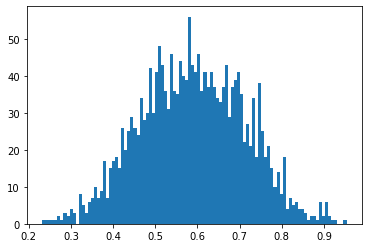

In [24]:
plt.hist(aucs_htom, bins=100)

In [25]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_m[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  6.,  1.,  0.,  1.,  2.,  5.,  2.,
        10.,  3.,  7.,  8.,  6.,  5.,  9., 16., 18., 17., 16., 16., 18.,
        17., 25., 23., 27., 27., 26., 33., 33., 34., 33., 29., 34., 39.,
        42., 34., 43., 45., 49., 44., 39., 33., 52., 39., 48., 44., 50.,
        48., 46., 44., 46., 40., 36., 40., 42., 40., 41., 29., 42., 28.,
        34., 31., 23., 25., 32., 19., 15., 17., 22., 14., 17.,  9.,  6.,
         6.,  3.,  6.,  3.,  6.,  6.,  8.,  0.,  2.,  2.,  4.,  4.,  1.,
         4.,  4.,  2.,  2.,  4.,  0.,  1.,  3.,  2.]),
 array([0.22745704, 0.23466495, 0.24187285, 0.24908076, 0.25628866,
        0.26349656, 0.27070447, 0.27791237, 0.28512027, 0.29232818,
        0.29953608, 0.30674399, 0.31395189, 0.32115979, 0.3283677 ,
        0.3355756 , 0.34278351, 0.34999141, 0.35719931, 0.36440722,
        0.37161512, 0.37882302, 0.38603093, 0.39323883, 0.40044674,
        0.40765464, 0.41486254, 0.42207045, 0.42927835, 0.43648625,
        0.44369416, 0.4509

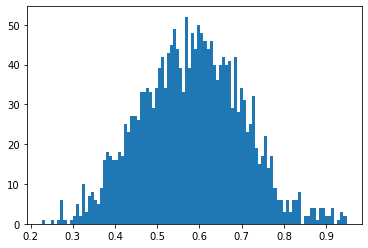

In [26]:
plt.hist(aucs_mtoh, bins=100)

In [27]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [28]:
gene_aucs

,mouse_auc,human_auc
Gene,,
AAMP,0.644656,0.609424
AARSD1,0.476280,0.579742
AASDHPPT,0.376735,0.392818
ABCC5,0.431203,0.429957
ABCE1,0.576529,0.587259
...,...,...
ZNF800,0.460816,0.542165
ZNF830,0.561735,0.528299
ZNHIT1,0.488308,0.326838


In [29]:
gene_aucs.to_csv("../../data/aucs.tsv.gz", sep="\t")

In [30]:
from scipy.stats import spearmanr
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.7853314492955118, pvalue=0.0)

In [31]:
?roc_auc_score

Signature:
roc_auc_score(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
)
Docstring:
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from prediction scores.

Note: this implementation can be used with binary, multiclass and
multilabel classification, but some restrictions apply (see Parameters).

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
    True labels or binary label indicators. The binary and multiclass cases
    expect labels with shape (n_samples,) while the multilabel case expects
    binary label indicators with shape (n_samples, n_classes).

y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
    Target scores.

    * In the binary case, it corresponds to an array of shape
      `(n_samples,)`. Both probability estimates and non-thresholded
      dec